In [1]:
#Math Part
import numpy as np
import pandas as pd
import time

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

<module 'gsvm' from 'c:\\Users\\londh\\qc\\Automatic_design_of_quantum_feature_maps_Genetic_Auto-Generation-main\\Qkrishi---QSVM\\gsvm.py'>

In [4]:
nqubits = 4
depth = 3
output="bank_testdata.csv"
df = pd.read_csv('bank_cleaned.csv')

bank_data = df.sample(n=2000,random_state=1)
#bank_data = np.around(bank_data)

y = bank_data['y'].values
# X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
            #   'day','month','duration','campaign','pdays','previous','poutcome']].values
X = bank_data[['age','job']].values
start = time.time()

pop, pareto, logbook = gsvm.gsvm(nqubits=nqubits, depth=depth, nparameters=2,
                                    X=X, y=y, weights=[-1.0,1.0],
                                    mu=100,lambda_=50,ngen=20,mutpb=0,cxpb=1)

print(f'Simulation finished after {time.time()-start} seconds')

print(f'\nGenetic-algorithm output ({output})')
print('---------------------------------------------')
with open(output, "w") as f:
    for ide, ind in enumerate(pareto):
        genes=''.join(str(i) for i in list(ind))
        gates, acc = ind.fitness.values
        line = f'{ide},"{genes}",{gates},{acc}'
        f.write(line)
        f.write('\n')
        print(line)

String: 001010000110001110010111110100100011010000110101101101011111
 -> accuracy = 0.56, gates = 9.0,recall = 0.6176470588235294
String: 111101000001001100101010000010100011111111110100101111101100
 -> accuracy = 0.555, gates = 10.0,recall = 0.6176470588235294
String: 111001110001011111101110000110101100101001011001101010100111
 -> accuracy = 0.56, gates = 10.0,recall = 0.6176470588235294
String: 011011101101110110010001001101010000100011010011110000111110
 -> accuracy = 0.5675, gates = 7.0,recall = 0.7941176470588235
String: 100010110010101000101001010001111010000110111001000000101110
 -> accuracy = 0.55, gates = 11.0,recall = 0.6078431372549019
String: 001011101111011101110000110100101000010011111000000100101110
 -> accuracy = 0.555, gates = 8.0,recall = 0.7450980392156863
String: 011101100111001110111111110010101110001010001111011011001001
 -> accuracy = 0.5975, gates = 6.0,recall = 0.7254901960784313
String: 011011100111111100110111100001110101100000001100101100011100
 -> accuracy

In [5]:
iot_result = pd.read_csv('bank_testdata.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','accuracy']
    dataframe.sort_values(['gates','accuracy'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,accuracy
0,154,0111011001110011101111111100111000100010000100...,2.411894,0.615
1,155,0111011001110001100111111100111000100011000111...,2.411894,0.615
2,156,0111011010110011101111111100111000100011000110...,2.411894,0.615
3,157,0111011001010011101111111100111000100011000111...,2.411894,0.615
4,158,0111011001110011101111111100111000100011000100...,2.411894,0.615
...,...,...,...,...
156,14,1101110001101111100001010010001100010101100100...,0.635200,0.520
157,0,1101110100110011011111011110111011001000010101...,0.000000,0.510
158,1,1101110100110101101001011101101101010110010101...,0.000000,0.510
159,2,1101110101101111100001010010001100010110110101...,0.000000,0.510


['01110', '11001', '11001', '11011', '11111', '10011', '10001', '00010', '00010', '01101', '10110', '01001']
7.0


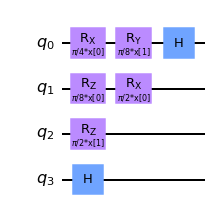

In [6]:
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit import QuantumRegister

def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

cc = CircuitConversor(nqubits=nqubits, nparameters=2)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
import matplotlib.pyplot as plt

In [8]:
def featuremap_performance(pop:str,nqubits:int) -> None:
    '''Returns the performance of a feature map on all of the dataset'''

    df = pd.read_csv('bank_cleaned.csv')
    bank_data = df.sample(n = 10000)

    y = bank_data['y'].values
    X = bank_data[['age','job','marital','education','default','balance',
                'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values


    fitness_obj = fitness.Fitness(nqubits,2,X,y,debug=True)

    training_features, training_labels, test_features, test_labels = fitness.Dataset(X,y)

    model = qsvm.QSVM(lambda parameters: fitness_obj.cc(pop, parameters)[0],training_features,training_labels)#fitness_obj(pop)

    y_pred = model.predict(test_features)

    cm = confusion_matrix(test_labels, y_pred)

    #cm_display = ConfusionMatrixDisplay(cm).plot()
    ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
    plt.show()
    recall = recall_score(test_labels, y_pred)
    acc  = accuracy_score(test_labels, y_pred)

    print(f'String = {pop},\n accuracy = {acc}, recall = {recall}')
    
    return None

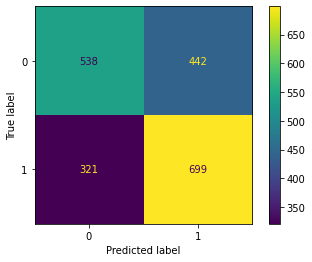

String = 011101100111001110111111110011100010001000010011011011001001,
 accuracy = 0.6185, recall = 0.6852941176470588


In [12]:
featuremap_performance(iot_salidas.circ[0],nqubits)

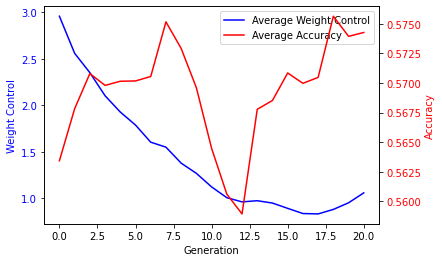

<Figure size 600x400 with 0 Axes>

In [10]:
gen = logbook.select("gen")
wc = logbook.chapters["wc"].select("media")
acc = logbook.chapters["acc"].select("media")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
plt.figure(dpi = 100)
line1 = ax1.plot(gen, wc ,"b-", label="Average Weight Control")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Weight Control", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, acc, "r-", label="Average Accuracy")
ax2.set_ylabel("Accuracy", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")

plt.show()